# ANALYSIS FOR TEXTUALVERIFIER ONLY

- Comparative analysis for 5 different number variants of TextualVerifier
- Author: Eugenius Mario Situmorang
- Date: June 2025

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import json
import re
from scipy import stats
from scipy.stats import fisher_exact
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## DATA LOADING AND PREPROCESSING FOR MULTIPLE VERSIONS

In [6]:
def load_multiple_versions():
    """
    Load all 5 versions of verification data
    """
    print("🔄 Loading multiple versions...")
    
    # Define file paths and version names
    version_files = {
        "Version 1": "results/textualverifier-1v.csv",
        "Version 2": "results/textualverifier-2v.csv", 
        "Version 3": "results/textualverifier-3v.csv",
        "Version 4": "results/textualverifier-4v.csv",
        "Version 5": "results/textualverifier-5v.csv"
    }
    
    dataframes = {}
    
    for version_name, file_path in version_files.items():
        try:
            df = pd.read_csv(file_path)
            
            # Add version identifier
            df['version'] = version_name
            
            # Basic preprocessing
            df['success'] = df['success'].astype(bool) if 'success' in df.columns else True
            
            # Handle answer correctness columns
            if 'original_answer_correctness' in df.columns:
                df['original_answer_correctness'] = df['original_answer_correctness'].str.strip().str.upper() == 'TRUE'
            if 'verifier_answer_correctness' in df.columns:
                df['verifier_answer_correctness'] = df['verifier_answer_correctness'].str.strip().str.upper() == 'TRUE'
            
            # Parse rating arrays
            def parse_rating_array(rating_str):
                try:
                    if pd.isna(rating_str):
                        return []
                    rating_str = str(rating_str).strip('[]')
                    return [int(x.strip()) for x in rating_str.split(',') if x.strip()]
                except:
                    return []
            
            if 'original_rating' in df.columns:
                df['original_rating_parsed'] = df['original_rating'].apply(parse_rating_array)
                df['original_avg_rating'] = df['original_rating_parsed'].apply(lambda x: np.mean(x) if x else np.nan)
            
            if 'verified_rating' in df.columns:
                df['verified_rating_parsed'] = df['verified_rating'].apply(parse_rating_array)
                df['verified_avg_rating'] = df['verified_rating_parsed'].apply(lambda x: np.mean(x) if x else np.nan)
            
            # Calculate derived metrics
            if 'original_avg_rating' in df.columns and 'verified_avg_rating' in df.columns:
                df['rating_improvement'] = df['verified_avg_rating'] - df['original_avg_rating']
            
            if 'verified_total_steps' in df.columns and 'original_total_steps' in df.columns:
                df['step_change'] = df['verified_total_steps'] - df['original_total_steps']
            
            if 'total_output_tokens' in df.columns and 'total_input_tokens' in df.columns:
                df['token_efficiency'] = df['total_output_tokens'] / (df['total_input_tokens'] + 1)
            
            dataframes[version_name] = df
            print(f"✅ {version_name}: {len(df)} records loaded")
            
        except Exception as e:
            print(f"❌ Error loading {version_name}: {e}")
            continue
    
    # Combine all dataframes
    if dataframes:
        combined_df = pd.concat(dataframes.values(), ignore_index=True)
        print(f"\n🎯 Total combined dataset: {len(combined_df)} records across {len(dataframes)} versions")
        return combined_df, dataframes
    else:
        print("❌ No data loaded successfully")
        return None, {}

# Load all versions
combined_df, version_dfs = load_multiple_versions()

🔄 Loading multiple versions...
✅ Version 1: 70 records loaded
✅ Version 2: 70 records loaded
✅ Version 3: 70 records loaded
✅ Version 4: 70 records loaded
✅ Version 5: 70 records loaded

🎯 Total combined dataset: 350 records across 5 versions


## MULTI-VERSION COMPARATIVE ANALYSIS

In [7]:
def comparative_foundational_analysis(combined_df):
    """
    Compare foundational metrics across all versions
    """
    print("\n" + "="*70)
    print("📈 COMPARATIVE FOUNDATIONAL ANALYSIS")
    print("="*70)
    
    results = {}
    
    # Group by version for analysis
    version_stats = combined_df.groupby('version').agg({
        'success': ['count', 'mean'],
        'original_answer_correctness': 'mean',
        'verifier_answer_correctness': 'mean', 
        'processing_time_ms': ['mean', 'median', 'std'],
        'total_llm_calls': ['mean', 'median'],
        'total_input_tokens': 'mean',
        'total_output_tokens': 'mean',
        'token_efficiency': ['mean', 'std']
    }).round(3)
    
    # Flatten column names
    version_stats.columns = ['_'.join(col).strip() for col in version_stats.columns]
    
    # Calculate accuracy improvements
    accuracy_improvements = {}
    for version in combined_df['version'].unique():
        version_data = combined_df[combined_df['version'] == version]
        original_acc = version_data['original_answer_correctness'].mean() * 100
        verified_acc = version_data['verifier_answer_correctness'].mean() * 100
        accuracy_improvements[version] = verified_acc - original_acc
    
    results['version_stats'] = version_stats
    results['accuracy_improvements'] = accuracy_improvements
    
    # Print comparison summary
    print("📊 VERSION COMPARISON SUMMARY:")
    print("-" * 50)
    
    for version in combined_df['version'].unique():
        version_data = combined_df[combined_df['version'] == version]
        success_rate = version_data['success'].mean() * 100
        accuracy_improvement = accuracy_improvements[version]
        avg_time = version_data['processing_time_ms'].mean()
        avg_llm_calls = version_data['total_llm_calls'].mean()
        
        print(f"\n{version}:")
        print(f"  • Success Rate: {success_rate:.1f}%")
        print(f"  • Accuracy Improvement: {accuracy_improvement:+.1f} pp")
        print(f"  • Avg Processing Time: {avg_time:.1f} ms")
        print(f"  • Avg LLM Calls: {avg_llm_calls:.1f}")
    
    # Statistical significance tests
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    print("-" * 40)
    
    versions = list(combined_df['version'].unique())
    
    # Compare success rates using Fisher's exact test (more robust than chi-square)
    if len(versions) >= 2:
        for i in range(len(versions)):
            for j in range(i+1, len(versions)):
                v1_success = combined_df[combined_df['version'] == versions[i]]['success']
                v2_success = combined_df[combined_df['version'] == versions[j]]['success']
                
                if len(v1_success) > 0 and len(v2_success) > 0:
                    try:
                        # Create contingency table
                        v1_successes = v1_success.sum()
                        v1_failures = len(v1_success) - v1_successes
                        v2_successes = v2_success.sum()
                        v2_failures = len(v2_success) - v2_successes
                        
                        contingency_table = [[v1_successes, v1_failures], 
                                           [v2_successes, v2_failures]]
                        
                        # Use Fisher's exact test for small samples or when chi-square assumptions violated
                        if any(cell < 5 for row in contingency_table for cell in row):
                            odds_ratio, p_value = fisher_exact(contingency_table)
                            test_used = "Fisher's exact"
                        else:
                            # Check if any expected frequencies are zero
                            total = sum(sum(row) for row in contingency_table)
                            row_totals = [sum(row) for row in contingency_table]
                            col_totals = [sum(contingency_table[i][j] for i in range(2)) for j in range(2)]
                            
                            expected_freq_valid = all(
                                (row_totals[i] * col_totals[j]) / total >= 1
                                for i in range(2) for j in range(2)
                            )
                            
                            if expected_freq_valid:
                                stat, p_value = stats.chi2_contingency(contingency_table)[:2]
                                test_used = "Chi-square"
                            else:
                                odds_ratio, p_value = fisher_exact(contingency_table)
                                test_used = "Fisher's exact"
                        
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                        print(f"  Success Rate {versions[i]} vs {versions[j]}: p={p_value:.4f} {significance} ({test_used})")
                        
                    except Exception as e:
                        # Fallback to simple proportion comparison
                        v1_rate = v1_success.mean()
                        v2_rate = v2_success.mean()
                        rate_diff = abs(v1_rate - v2_rate)
                        print(f"  Success Rate {versions[i]} vs {versions[j]}: Rate diff={rate_diff:.3f} (comparison failed: {str(e)[:50]}...)")
    
    return results

# Run comparative foundational analysis
comp_results_1 = comparative_foundational_analysis(combined_df)


📈 COMPARATIVE FOUNDATIONAL ANALYSIS
📊 VERSION COMPARISON SUMMARY:
--------------------------------------------------

Version 1:
  • Success Rate: 100.0%
  • Accuracy Improvement: +1.4 pp
  • Avg Processing Time: 66464.9 ms
  • Avg LLM Calls: 18.8

Version 2:
  • Success Rate: 100.0%
  • Accuracy Improvement: +1.4 pp
  • Avg Processing Time: 196097.7 ms
  • Avg LLM Calls: 56.4

Version 3:
  • Success Rate: 100.0%
  • Accuracy Improvement: +2.9 pp
  • Avg Processing Time: 227156.2 ms
  • Avg LLM Calls: 75.1

Version 4:
  • Success Rate: 100.0%
  • Accuracy Improvement: +5.7 pp
  • Avg Processing Time: 253619.8 ms
  • Avg LLM Calls: 93.9

Version 5:
  • Success Rate: 100.0%
  • Accuracy Improvement: +0.0 pp
  • Avg Processing Time: 327053.2 ms
  • Avg LLM Calls: 112.7

🔬 STATISTICAL SIGNIFICANCE TESTS:
----------------------------------------
  Success Rate Version 1 vs Version 2: p=1.0000 ns (Fisher's exact)
  Success Rate Version 1 vs Version 3: p=1.0000 ns (Fisher's exact)
  Success 

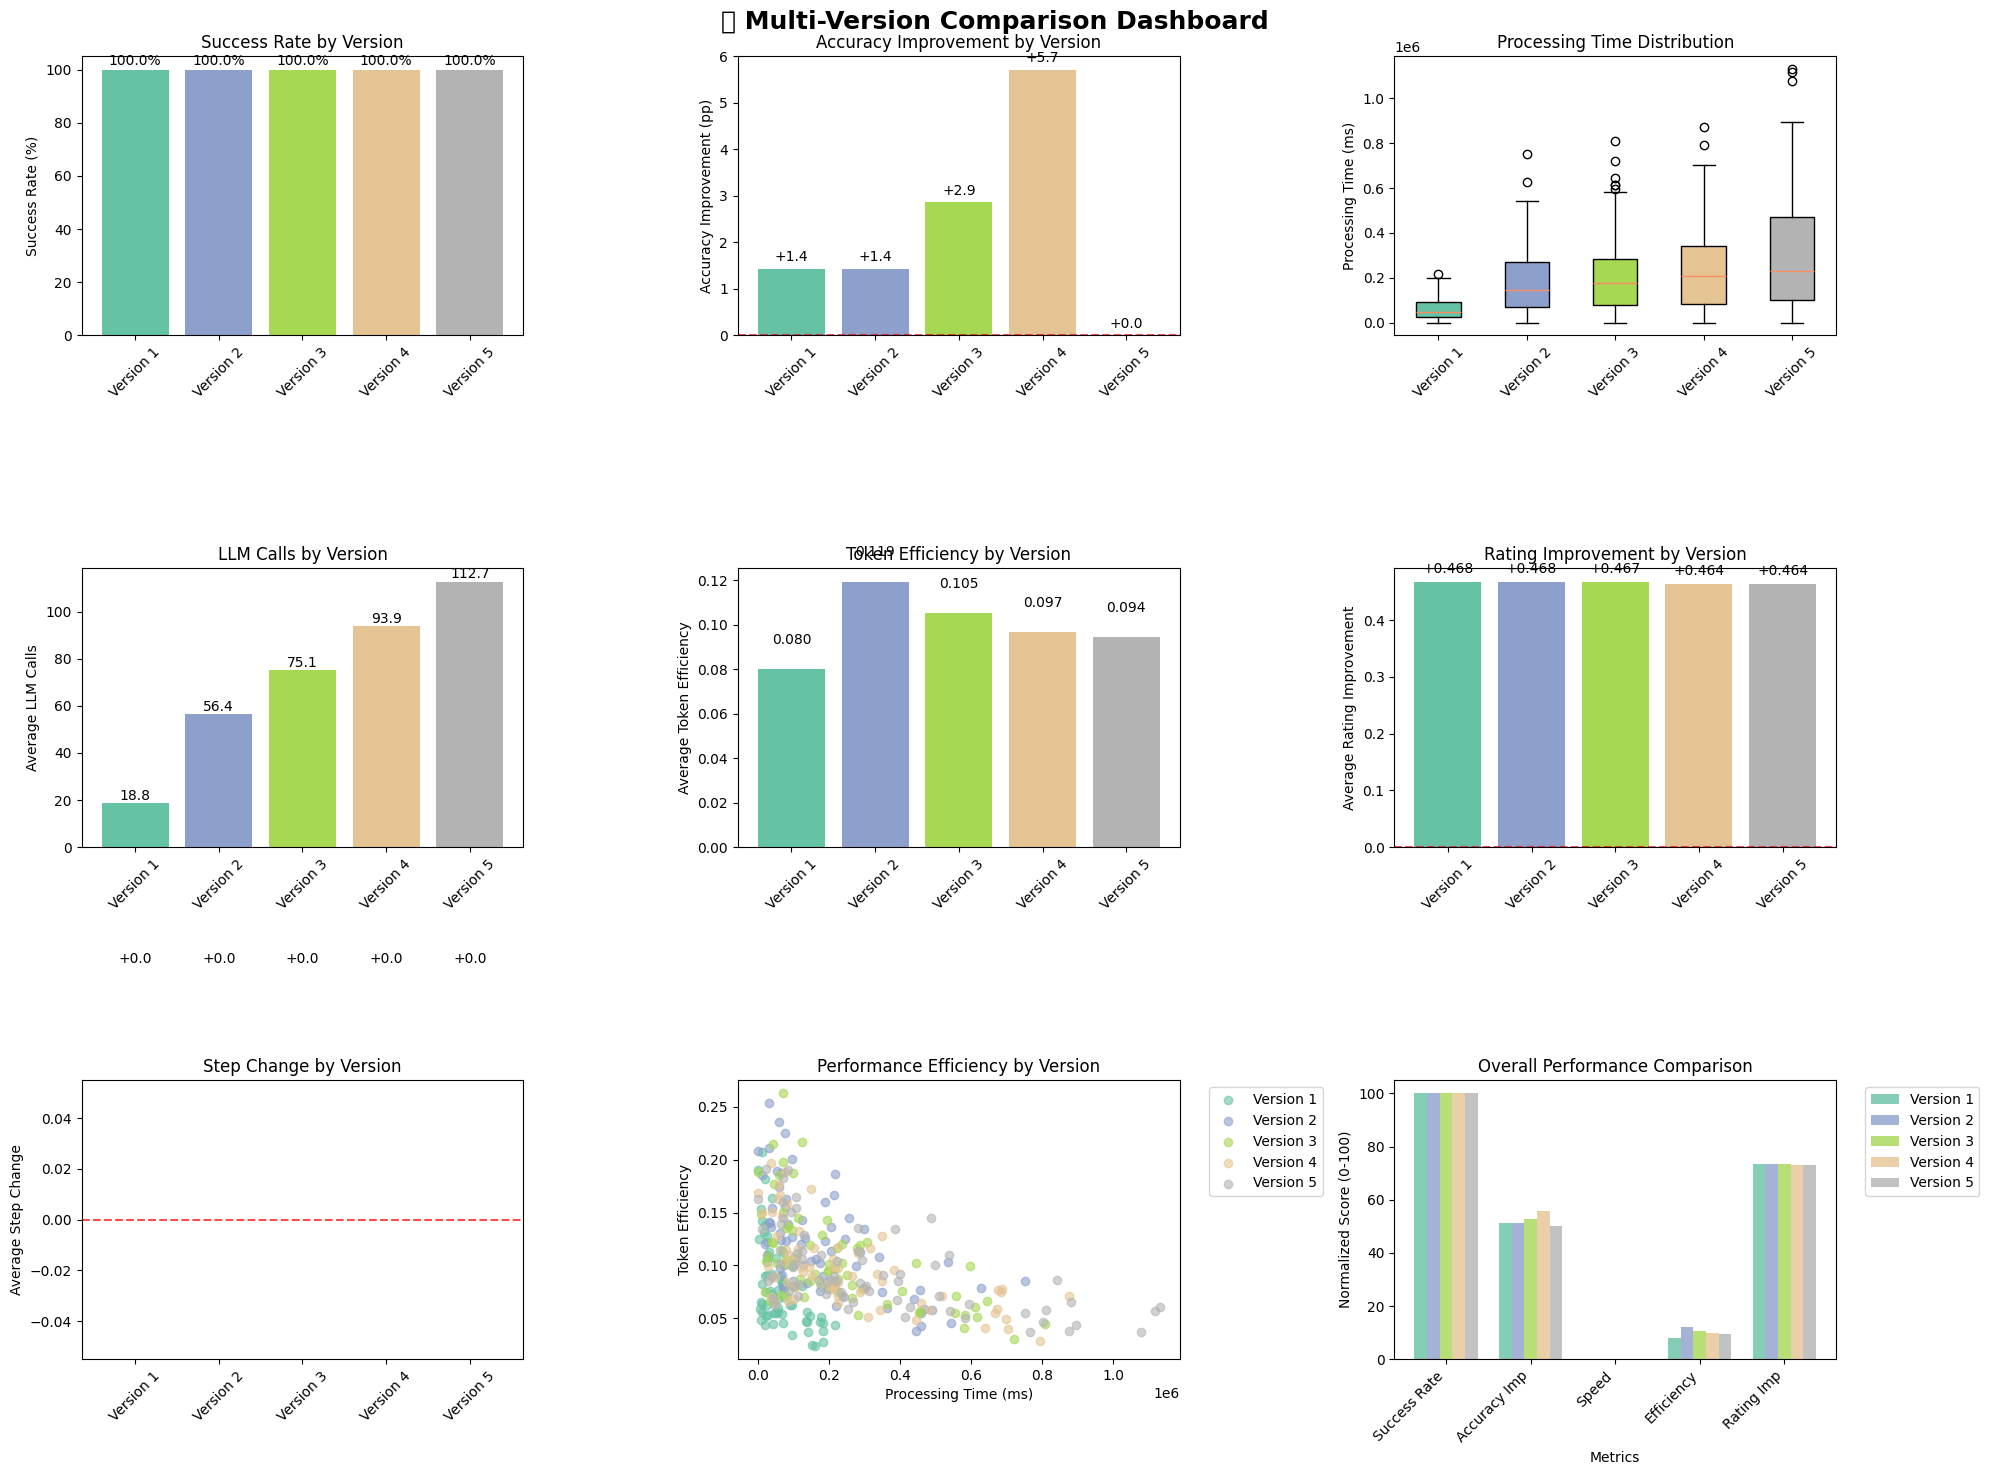

In [8]:
# Visualization for Multi-Version Comparison
def visualize_version_comparison(combined_df):
    """
    Create comprehensive visualizations comparing all versions
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('🔍 Multi-Version Comparison Dashboard', fontsize=18, fontweight='bold')
    
    versions = combined_df['version'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(versions)))
    
    # 1. Success Rate Comparison
    success_rates = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        success_rates.append(version_data['success'].mean() * 100)
    
    bars1 = axes[0,0].bar(versions, success_rates, color=colors)
    axes[0,0].set_ylabel('Success Rate (%)')
    axes[0,0].set_title('Success Rate by Version')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars1, success_rates):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                      f'{value:.1f}%', ha='center', va='bottom')
    
    # 2. Accuracy Improvement Comparison  
    accuracy_improvements = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        original_acc = version_data['original_answer_correctness'].mean() * 100
        verified_acc = version_data['verifier_answer_correctness'].mean() * 100
        accuracy_improvements.append(verified_acc - original_acc)
    
    bars2 = axes[0,1].bar(versions, accuracy_improvements, color=colors)
    axes[0,1].set_ylabel('Accuracy Improvement (pp)')
    axes[0,1].set_title('Accuracy Improvement by Version')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    for bar, value in zip(bars2, accuracy_improvements):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if value >= 0 else -0.3), 
                      f'{value:+.1f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    # 3. Processing Time Distribution
    processing_times_by_version = []
    labels = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        times = version_data['processing_time_ms'].dropna()
        if len(times) > 0:
            processing_times_by_version.append(times)
            labels.append(version)
    
    if processing_times_by_version:
        bp1 = axes[0,2].boxplot(processing_times_by_version, labels=labels, patch_artist=True)
        for patch, color in zip(bp1['boxes'], colors):
            patch.set_facecolor(color)
    axes[0,2].set_ylabel('Processing Time (ms)')
    axes[0,2].set_title('Processing Time Distribution')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. LLM Calls Comparison
    llm_calls_avg = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        llm_calls_avg.append(version_data['total_llm_calls'].mean())
    
    bars3 = axes[1,0].bar(versions, llm_calls_avg, color=colors)
    axes[1,0].set_ylabel('Average LLM Calls')
    axes[1,0].set_title('LLM Calls by Version')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars3, llm_calls_avg):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                      f'{value:.1f}', ha='center', va='bottom')
    
    # 5. Token Efficiency Comparison
    token_efficiency_avg = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        token_efficiency_avg.append(version_data['token_efficiency'].mean())
    
    bars4 = axes[1,1].bar(versions, token_efficiency_avg, color=colors)
    axes[1,1].set_ylabel('Average Token Efficiency')
    axes[1,1].set_title('Token Efficiency by Version')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars4, token_efficiency_avg):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{value:.3f}', ha='center', va='bottom')
    
    # 6. Rating Improvement Comparison
    rating_improvements = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        rating_imp = version_data['rating_improvement'].dropna().mean()
        rating_improvements.append(rating_imp if not pd.isna(rating_imp) else 0)
    
    bars5 = axes[1,2].bar(versions, rating_improvements, color=colors)
    axes[1,2].set_ylabel('Average Rating Improvement')
    axes[1,2].set_title('Rating Improvement by Version')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    for bar, value in zip(bars5, rating_improvements):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value >= 0 else -0.02), 
                      f'{value:+.3f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    # 7. Step Change Comparison
    step_changes = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        step_change = version_data['step_change'].dropna().mean()
        step_changes.append(step_change if not pd.isna(step_change) else 0)
    
    bars6 = axes[2,0].bar(versions, step_changes, color=colors)
    axes[2,0].set_ylabel('Average Step Change')
    axes[2,0].set_title('Step Change by Version')
    axes[2,0].tick_params(axis='x', rotation=45)
    axes[2,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    for bar, value in zip(bars6, step_changes):
        axes[2,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if value >= 0 else -0.2), 
                      f'{value:+.1f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    # 8. Performance Efficiency Scatter (Time vs Token Efficiency)
    for i, version in enumerate(versions):
        version_data = combined_df[combined_df['version'] == version]
        valid_data = version_data.dropna(subset=['processing_time_ms', 'token_efficiency'])
        if len(valid_data) > 0:
            axes[2,1].scatter(valid_data['processing_time_ms'], valid_data['token_efficiency'], 
                            label=version, alpha=0.6, color=colors[i])
    
    axes[2,1].set_xlabel('Processing Time (ms)')
    axes[2,1].set_ylabel('Token Efficiency')
    axes[2,1].set_title('Performance Efficiency by Version')
    axes[2,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 9. Overall Performance Radar Chart (simplified)
    metrics = ['Success Rate', 'Accuracy Imp', 'Speed', 'Efficiency', 'Rating Imp']
    
    # Normalize metrics to 0-100 scale for comparison
    normalized_data = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        
        # Normalize each metric
        success_norm = version_data['success'].mean() * 100
        acc_imp_norm = max(0, (version_data['verifier_answer_correctness'].mean() - 
                              version_data['original_answer_correctness'].mean()) * 100 + 50)
        speed_norm = max(0, 100 - (version_data['processing_time_ms'].mean() / 5))  # Inverse for speed
        efficiency_norm = min(100, version_data['token_efficiency'].mean() * 100)
        rating_norm = max(0, version_data['rating_improvement'].dropna().mean() * 50 + 50)
        
        normalized_data.append([success_norm, acc_imp_norm, speed_norm, efficiency_norm, rating_norm])
    
    # Create a simple bar chart instead of radar for better visibility
    x_pos = np.arange(len(metrics))
    width = 0.15
    
    for i, (version, data) in enumerate(zip(versions, normalized_data)):
        axes[2,2].bar(x_pos + i * width, data, width, label=version, color=colors[i], alpha=0.8)
    
    axes[2,2].set_xlabel('Metrics')
    axes[2,2].set_ylabel('Normalized Score (0-100)')
    axes[2,2].set_title('Overall Performance Comparison')
    axes[2,2].set_xticks(x_pos + width * 2)
    axes[2,2].set_xticklabels(metrics, rotation=45, ha='right')
    axes[2,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

visualize_version_comparison(combined_df)

## DETAILED VERSION RANKING ANALYSIS

In [9]:
def comprehensive_version_ranking(combined_df):
    """
    Create comprehensive ranking system for all versions
    """
    print("\n" + "="*70)
    print("🏆 COMPREHENSIVE VERSION RANKING ANALYSIS")
    print("="*70)
    
    versions = combined_df['version'].unique()
    ranking_data = {}
    
    # Define metrics and their weights
    metrics = {
        'success_rate': {'weight': 0.25, 'higher_better': True},
        'accuracy_improvement': {'weight': 0.25, 'higher_better': True},
        'processing_speed': {'weight': 0.20, 'higher_better': True},  # Inverse of time
        'token_efficiency': {'weight': 0.15, 'higher_better': True},
        'rating_improvement': {'weight': 0.15, 'higher_better': True}
    }
    
    # Calculate metrics for each version
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        
        # Success rate (0-100)
        success_rate = version_data['success'].mean() * 100
        
        # Accuracy improvement (-100 to +100)
        accuracy_improvement = (version_data['verifier_answer_correctness'].mean() - 
                               version_data['original_answer_correctness'].mean()) * 100
        
        # Processing speed (inverse of time, normalized)
        avg_time = version_data['processing_time_ms'].mean()
        processing_speed = 1000 / avg_time if avg_time > 0 else 0  # Operations per second
        
        # Token efficiency
        token_efficiency = version_data['token_efficiency'].mean()
        
        # Rating improvement
        rating_improvement = version_data['rating_improvement'].dropna().mean()
        if pd.isna(rating_improvement):
            rating_improvement = 0
        
        ranking_data[version] = {
            'success_rate': success_rate,
            'accuracy_improvement': accuracy_improvement,
            'processing_speed': processing_speed,
            'token_efficiency': token_efficiency,
            'rating_improvement': rating_improvement,
            'avg_processing_time': avg_time,
            'total_problems': len(version_data)
        }
    
    # Normalize metrics to 0-100 scale
    normalized_data = {}
    
    for metric in metrics.keys():
        values = [ranking_data[version][metric] for version in versions]
        
        if metrics[metric]['higher_better']:
            min_val, max_val = min(values), max(values)
            if max_val > min_val:
                for version in versions:
                    if version not in normalized_data:
                        normalized_data[version] = {}
                    normalized_data[version][metric] = ((ranking_data[version][metric] - min_val) / 
                                                       (max_val - min_val)) * 100
            else:
                for version in versions:
                    if version not in normalized_data:
                        normalized_data[version] = {}
                    normalized_data[version][metric] = 100
    
    # Calculate weighted scores
    final_scores = {}
    for version in versions:
        total_score = 0
        for metric, config in metrics.items():
            total_score += normalized_data[version][metric] * config['weight']
        final_scores[version] = total_score
    
    # Create ranking
    sorted_versions = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Print detailed ranking
    print("🥇 FINAL RANKING:")
    print("=" * 50)
    
    for rank, (version, score) in enumerate(sorted_versions, 1):
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
        print(f"\n{medal} {version} - Overall Score: {score:.1f}/100")
        print(f"   Success Rate: {ranking_data[version]['success_rate']:.1f}%")
        print(f"   Accuracy Improvement: {ranking_data[version]['accuracy_improvement']:+.1f} pp")
        print(f"   Avg Processing Time: {ranking_data[version]['avg_processing_time']:.1f} ms")
        print(f"   Token Efficiency: {ranking_data[version]['token_efficiency']:.3f}")
        print(f"   Rating Improvement: {ranking_data[version]['rating_improvement']:+.3f}")
        print(f"   Total Problems: {ranking_data[version]['total_problems']}")
    
    # Detailed metric breakdown
    print(f"\n📊 DETAILED METRIC BREAKDOWN:")
    print("=" * 50)
    
    metric_rankings = {}
    for metric in metrics.keys():
        metric_scores = [(version, normalized_data[version][metric]) for version in versions]
        metric_scores.sort(key=lambda x: x[1], reverse=True)
        metric_rankings[metric] = metric_scores
        
        print(f"\n{metric.replace('_', ' ').title()}:")
        for rank, (version, score) in enumerate(metric_scores, 1):
            print(f"   {rank}. {version}: {score:.1f}/100")
    
    return {
        'final_ranking': sorted_versions,
        'metric_rankings': metric_rankings,
        'raw_data': ranking_data,
        'normalized_data': normalized_data
    }

# Run comprehensive ranking
ranking_results = comprehensive_version_ranking(combined_df)


🏆 COMPREHENSIVE VERSION RANKING ANALYSIS
🥇 FINAL RANKING:

🥇 Version 1 - Overall Score: 66.3/100
   Success Rate: 100.0%
   Accuracy Improvement: +1.4 pp
   Avg Processing Time: 66464.9 ms
   Token Efficiency: 0.080
   Rating Improvement: +0.468
   Total Problems: 70

🥈 Version 2 - Overall Score: 63.1/100
   Success Rate: 100.0%
   Accuracy Improvement: +1.4 pp
   Avg Processing Time: 196097.7 ms
   Token Efficiency: 0.119
   Rating Improvement: +0.468
   Total Problems: 70

🥉 Version 3 - Overall Score: 62.2/100
   Success Rate: 100.0%
   Accuracy Improvement: +2.9 pp
   Avg Processing Time: 227156.2 ms
   Token Efficiency: 0.105
   Rating Improvement: +0.467
   Total Problems: 70

4. Version 4 - Overall Score: 57.9/100
   Success Rate: 100.0%
   Accuracy Improvement: +5.7 pp
   Avg Processing Time: 253619.8 ms
   Token Efficiency: 0.097
   Rating Improvement: +0.464
   Total Problems: 70

5. Version 5 - Overall Score: 32.9/100
   Success Rate: 100.0%
   Accuracy Improvement: +0.0 pp


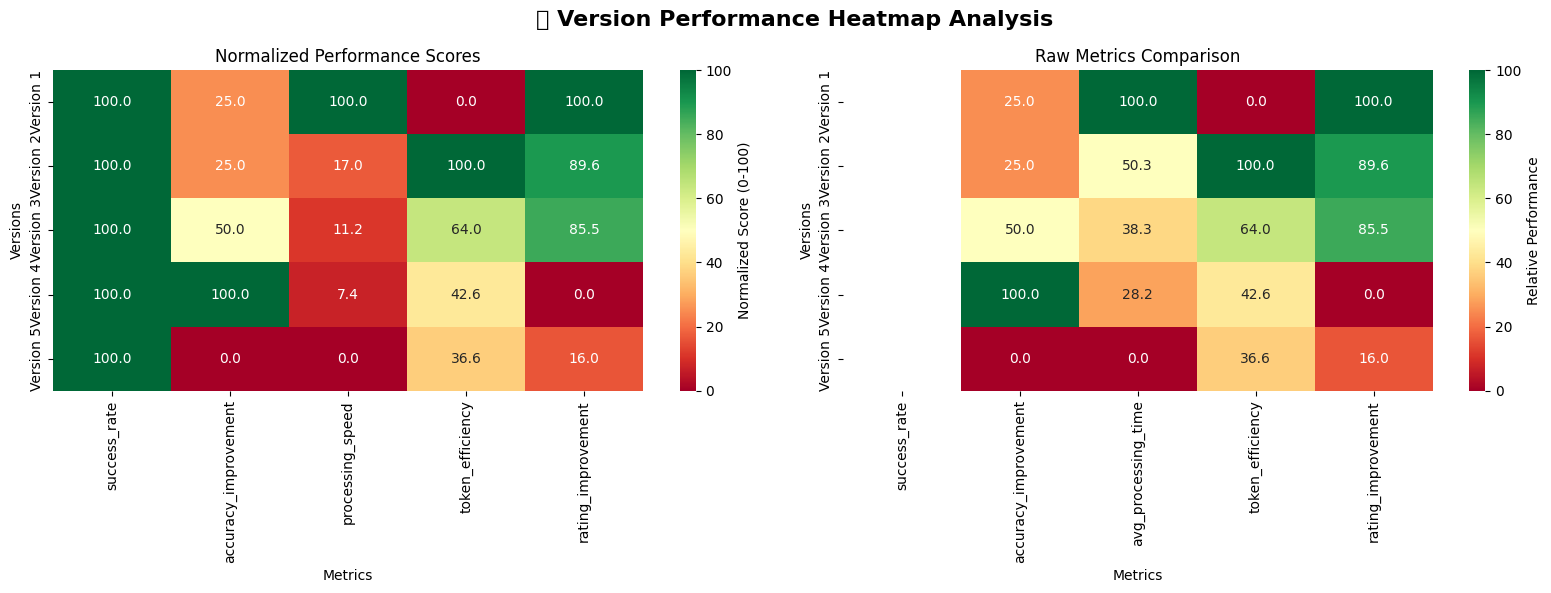


📋 RAW VALUES REFERENCE TABLE:
           success_rate  accuracy_improvement  avg_processing_time  token_efficiency  rating_improvement
Version 1         100.0                 1.429            66464.917             0.080               0.468
Version 2         100.0                 1.429           196097.675             0.119               0.468
Version 3         100.0                 2.857           227156.172             0.105               0.467
Version 4         100.0                 5.714           253619.806             0.097               0.464
Version 5         100.0                 0.000           327053.242             0.094               0.464


In [10]:
# Version Performance Heatmap
def create_performance_heatmap(ranking_results):
    """
    Create a performance heatmap for all versions across all metrics
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('🔥 Version Performance Heatmap Analysis', fontsize=16, fontweight='bold')
    
    # Prepare data for heatmap
    versions = list(ranking_results['normalized_data'].keys())
    metrics = list(ranking_results['normalized_data'][versions[0]].keys())
    
    # Create matrix for normalized scores
    heatmap_data = []
    for version in versions:
        row = [ranking_results['normalized_data'][version][metric] for metric in metrics]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, index=versions, columns=metrics)
    
    # Normalized performance heatmap
    sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn', 
                ax=axes[0], cbar_kws={'label': 'Normalized Score (0-100)'})
    axes[0].set_title('Normalized Performance Scores')
    axes[0].set_xlabel('Metrics')
    axes[0].set_ylabel('Versions')
    
    # Raw values heatmap
    raw_metrics = ['success_rate', 'accuracy_improvement', 'avg_processing_time', 
                   'token_efficiency', 'rating_improvement']
    raw_data = []
    for version in versions:
        row = [ranking_results['raw_data'][version][metric] for metric in raw_metrics]
        raw_data.append(row)
    
    raw_df = pd.DataFrame(raw_data, index=versions, columns=raw_metrics)
    
    # Normalize raw data for heatmap visualization
    raw_df_normalized = raw_df.copy()
    for col in raw_df_normalized.columns:
        if col == 'avg_processing_time':  # Lower is better for processing time
            raw_df_normalized[col] = 100 - ((raw_df_normalized[col] - raw_df_normalized[col].min()) / 
                                           (raw_df_normalized[col].max() - raw_df_normalized[col].min()) * 100)
        else:  # Higher is better for other metrics
            raw_df_normalized[col] = ((raw_df_normalized[col] - raw_df_normalized[col].min()) / 
                                     (raw_df_normalized[col].max() - raw_df_normalized[col].min()) * 100)
    
    sns.heatmap(raw_df_normalized, annot=True, fmt='.1f', cmap='RdYlGn',
                ax=axes[1], cbar_kws={'label': 'Relative Performance'})
    axes[1].set_title('Raw Metrics Comparison')
    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('Versions')
    
    plt.tight_layout()
    plt.show()
    
    # Print raw values table for reference
    print("\n📋 RAW VALUES REFERENCE TABLE:")
    print("=" * 60)
    print(raw_df.round(3).to_string())

create_performance_heatmap(ranking_results)

# STATISTICAL ANALYSIS AND RECOMMENDATIONS